In [ ]:
from datetime import datetime

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 3.25, 3
plt.rcParams['figure.dpi'] = 150

import pandas as pd
# import xarray as xr
from pathlib import Path
from scipy.integrate import trapz, cumtrapz


# Utilities

In [ ]:

def get_trapz(df, by=None, x='Time [Sec]', y=None):
    """
    Perform integration on dataframe
    
    Parameter
    ---------
    df : dataframe
    by : str or array of str, optional
        names to groupby.  If not specified,
        integral over entire frame
    x : str
        column to use as "x" values
    y : str or array of str, optional
        columns of "y" data.  If not specified, 
        use all columns except `x`
    
    Returns
    -------
    output : dataframe
        dataframe integrated over `x`
    """
    # total integrals
    if y is None:
        y = list(df.columns.drop(x))
    elif isinstance(y, str):
        y = [y]
        
    if by is None:
        out = df.iloc[[0],:].loc[:, y].copy()
        out.loc[:, y] = trapz(y=df.loc[:, y].values, x=df[x].values, axis=0)
    else:
        # recursive call
        out = pd.concat((get_trapz(g, by=None, x=x, y=y) for _, g in df.groupby(by)))
        
    return out
    
def get_cumtrapz(df, by=None, x='Time [Sec]', y=None):
    """
    Perform cumulative integration on dataframe
    
    Parameter
    ---------
    df : dataframe
    by : str or array of str, optional
        names to groupby.  If not specified,
        integral over entire frame
    x : str
        column to use as "x" values
    y : str or array of str, optional
        columns of "y" data.  If not specified, 
        use all columns except `x`
    
    Returns
    -------
    output : dataframe
        dataframe integrated over `x`
    """
    
    if y is None:
        y = list(df.columns.drop(x))
    elif isinstance(y, str):
        y = [y]
    
    if by is not None:
        return pd.concat((get_cumtrapz(g, by=None, x=x, y=y) for _, g in df.groupby(by)))
    
    if by is None:
        out = df.loc[:, [x] + y].copy()
        out.loc[:, y] = cumtrapz(y=df.loc[:, y].values, x=df.loc[:, x].values, initial=0, axis=0)
    else:
        out = pd.concat((get_cumtrapz(g, by=None, x=x, y=y) for _, g in df.groupby(by)))
    return out
        


In [ ]:
def meta_list_to_dict(meta):
    out = {}
    out['data_path'] = meta[0]
    out['info'] = meta[1].strip()
    time_batch = ':'.join((meta[2].split(':'))[1:]).split('using Batch')
    out['aquired_time'] = time_batch[0].strip()
    out['batch'] = time_batch[1].strip()
    out['printed_time'] = ':'.join(meta[3].split(':')[1:])
    
    # convert datetimes
    for k in ['aquired_time','printed_time']:
        out[k] = datetime.strptime(out[k], '%Y-%m-%d %H:%M:%S')
    return out


def read_csv_meta(path, nrow=3, **kws):
    with open(path, 'r') as f:
        # grap metadata from first rows
        meta = [f.readline().strip() for _ in range(nrow) ]
        df = pd.read_csv(f, **kws)
    # grab last line     
    meta.append(df.iloc[-1, 0].strip())
    # pop last row, and make sure all numeric
    df = df.iloc[:-1].applymap(pd.to_numeric)
    
    return meta, df
        


def load_paths(paths):
    L = []
    for path in paths:
        # analyze a single path
        meta, df = read_csv_meta(path)
        meta = meta_list_to_dict(meta)
        meta['read_path'] = str(path)
        meta_keys = list(meta.keys())


        L.append(df.assign(**meta))

    df = (
        pd.concat(L)
        .set_index(meta_keys)
    )    
    return df


# Analyze Files

In [ ]:
# get local files
paths = list(Path('.').glob('*.csv'))
df = load_paths(paths)

meta_keys = df.index.names

# total integral
df_trap = get_trapz(df, meta_keys)

# cum integral
df_cumtrap = get_cumtrapz(df, meta_keys)

In [ ]:
df_trap.head()

In [ ]:
# last time of cumtrap should be same as trapz
pd.testing.assert_frame_equal(
    df_cumtrap.groupby(df_cumtrap.index.names).agg(lambda x: x.iloc[-1]).drop('Time [Sec]', axis=1),
    df_trap)

# look at results

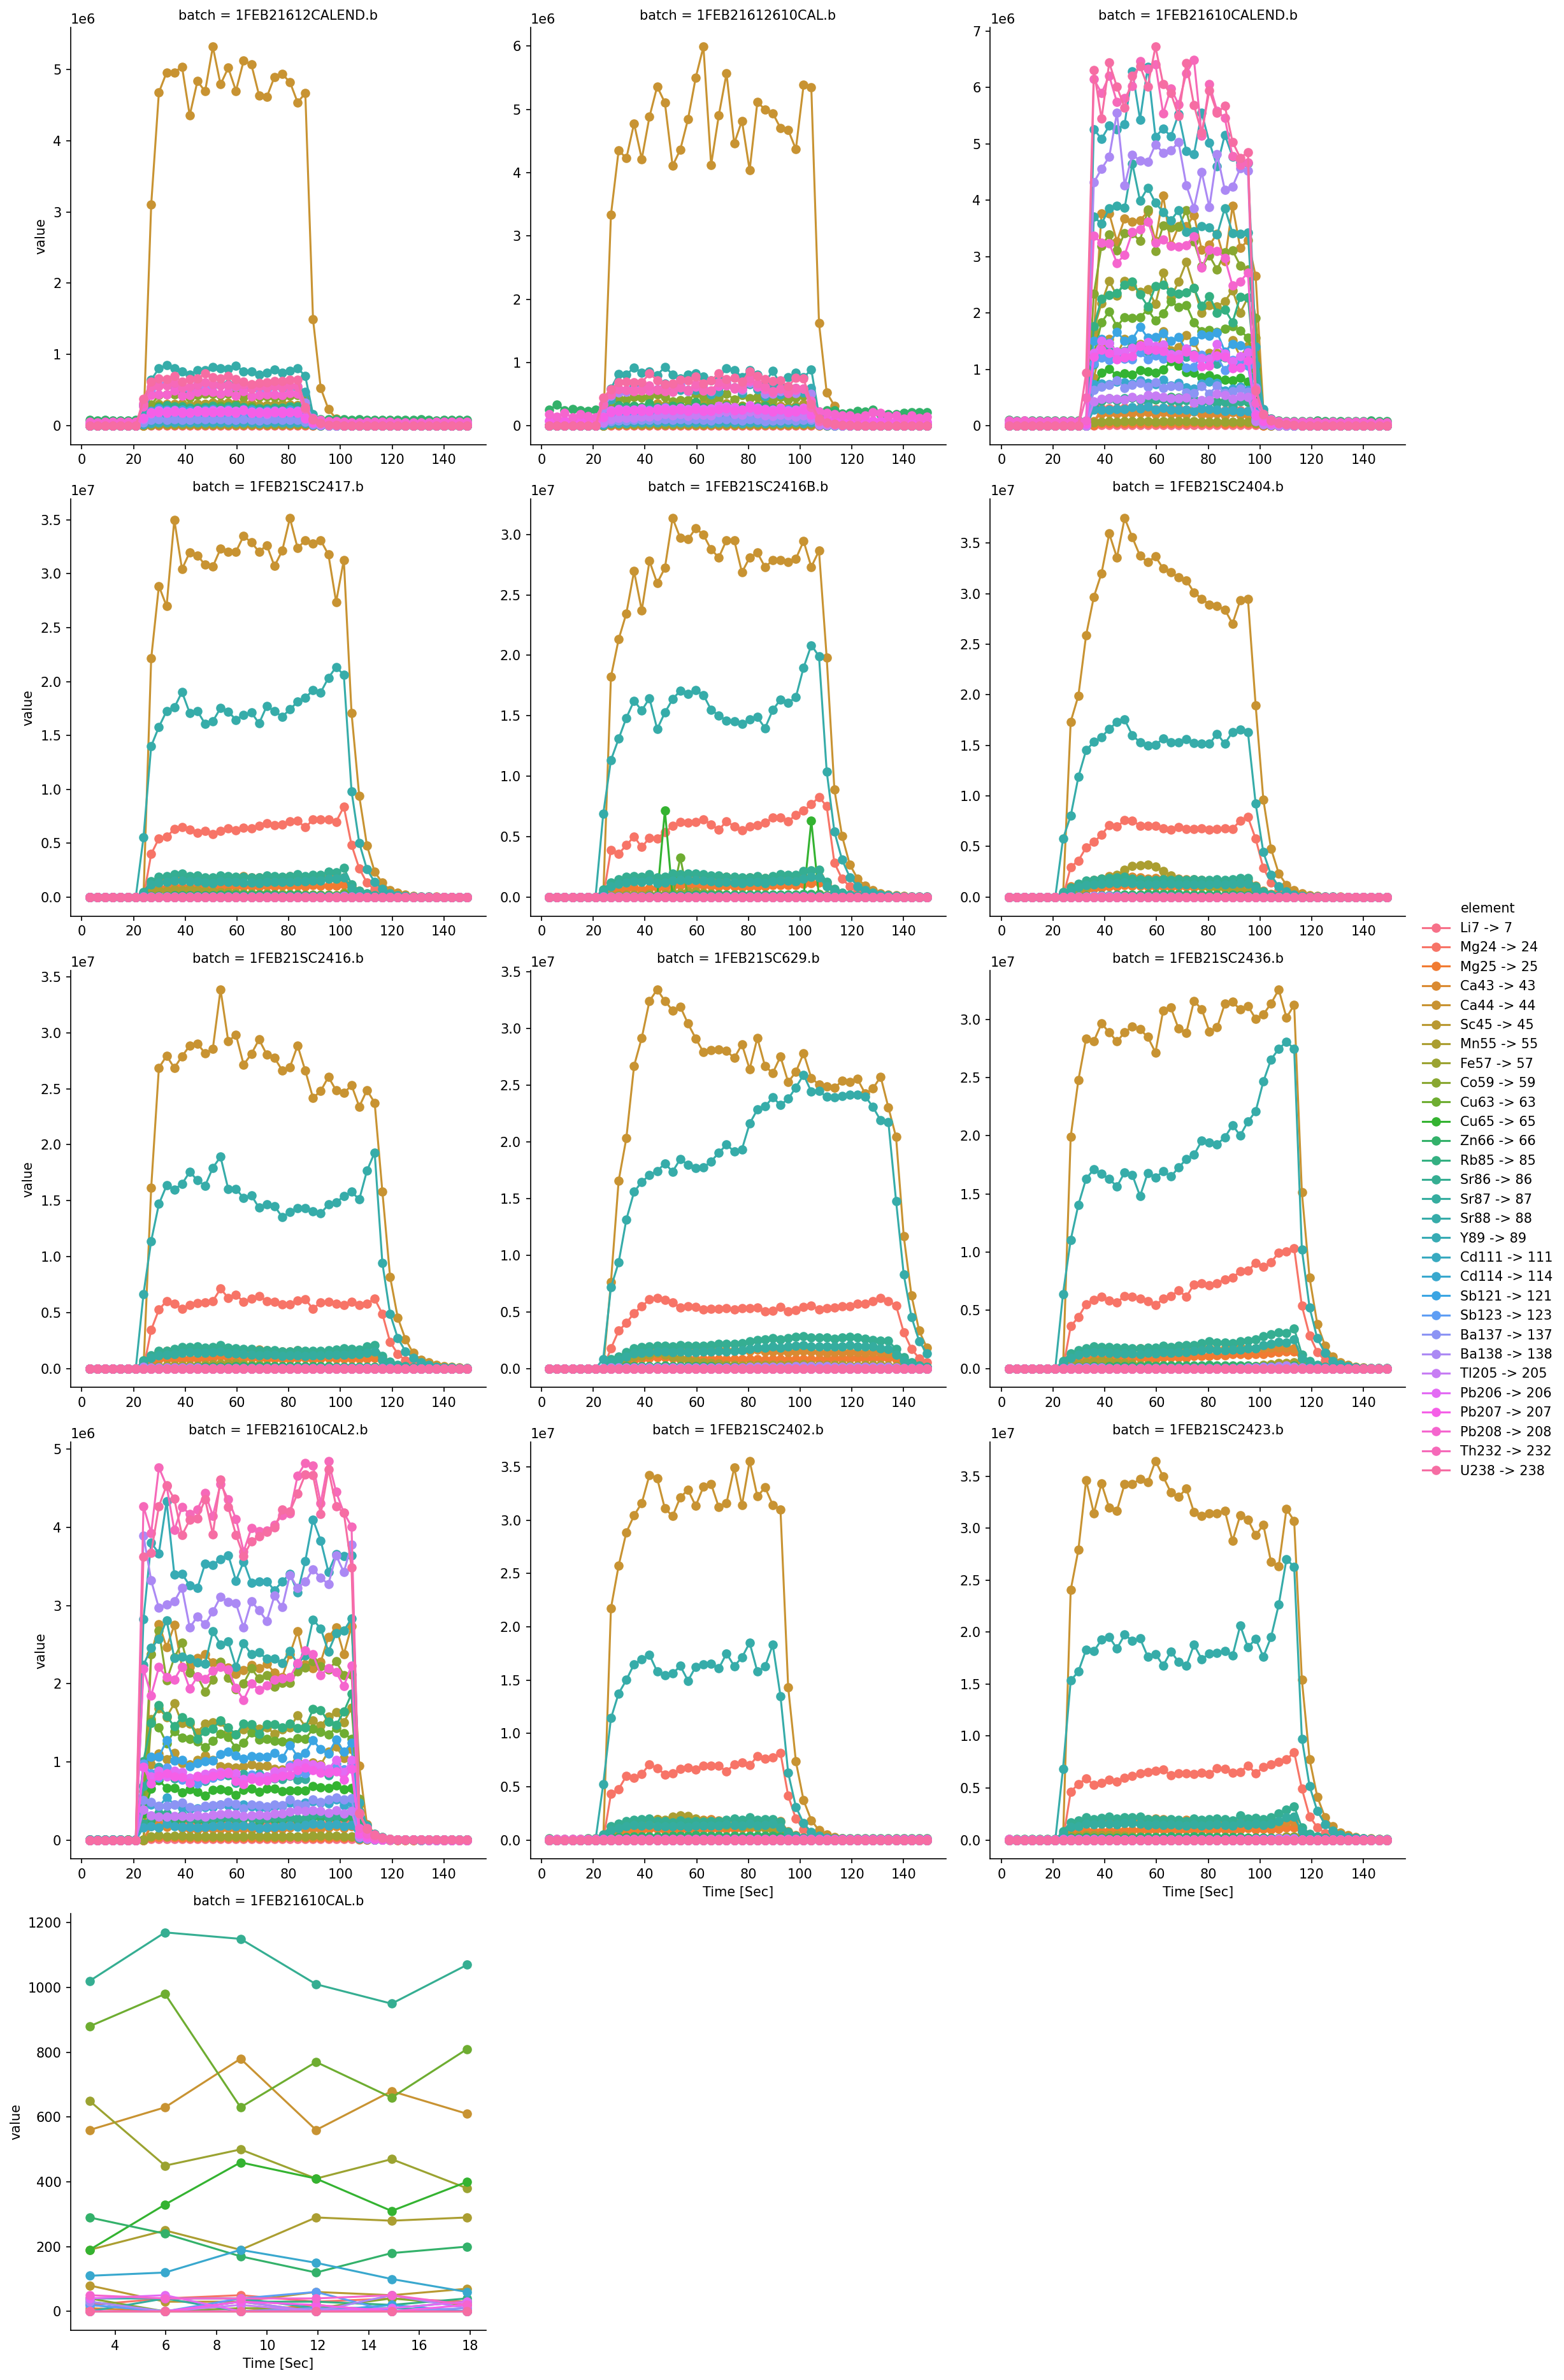

In [14]:
(
    df.reset_index(['batch']).melt(['batch','Time [Sec]'], var_name='element')
    .pipe(sns.FacetGrid, col='batch', col_wrap=3, hue='element', sharey=False, sharex=False, height=5)
    .map(plt.plot, 'Time [Sec]','value', marker='o')
    .add_legend()
)

#plt.tight_layout()

In [ ]:
(
    df.groupby(df.index.names).transform(lambda x: x.where(x > 0.7 * x.median()))
    .assign(**{'Time [Sec]': df['Time [Sec]']})b
    .reset_index(['batch']).melt(['batch','Time [Sec]'], var_name='element')
    .pipe(sns.FacetGrid, col='batch', col_wrap=3, hue='element', sharey=False, sharex=False, height=5)
    .map(plt.plot, 'Time [Sec]','value', marker='o')
    .add_legend()
    
    
)

In [ ]:
df.head()

In [ ]:
df_trap

In [ ]:
# only considering some values

(
    df.groupby(df.index.names).transform(lambda x: x.where(x > 0.7 * x.median()))
    .fillna(0.0)
    .assign(**{'Time [Sec]': df['Time [Sec]']})
    .pipe(get_trapz, by=df.index.names)
#     .reset_index(['batch']).melt(['batch','Time [Sec]'], var_name='element')
#     .pipe(sns.FacetGrid, col='batch', col_wrap=3, hue='element', sharey=False, sharex=False, height=5)
#     .map(plt.plot, 'Time [Sec]','value', marker='o')
#     .add_legend()
    
    / df_trap
)

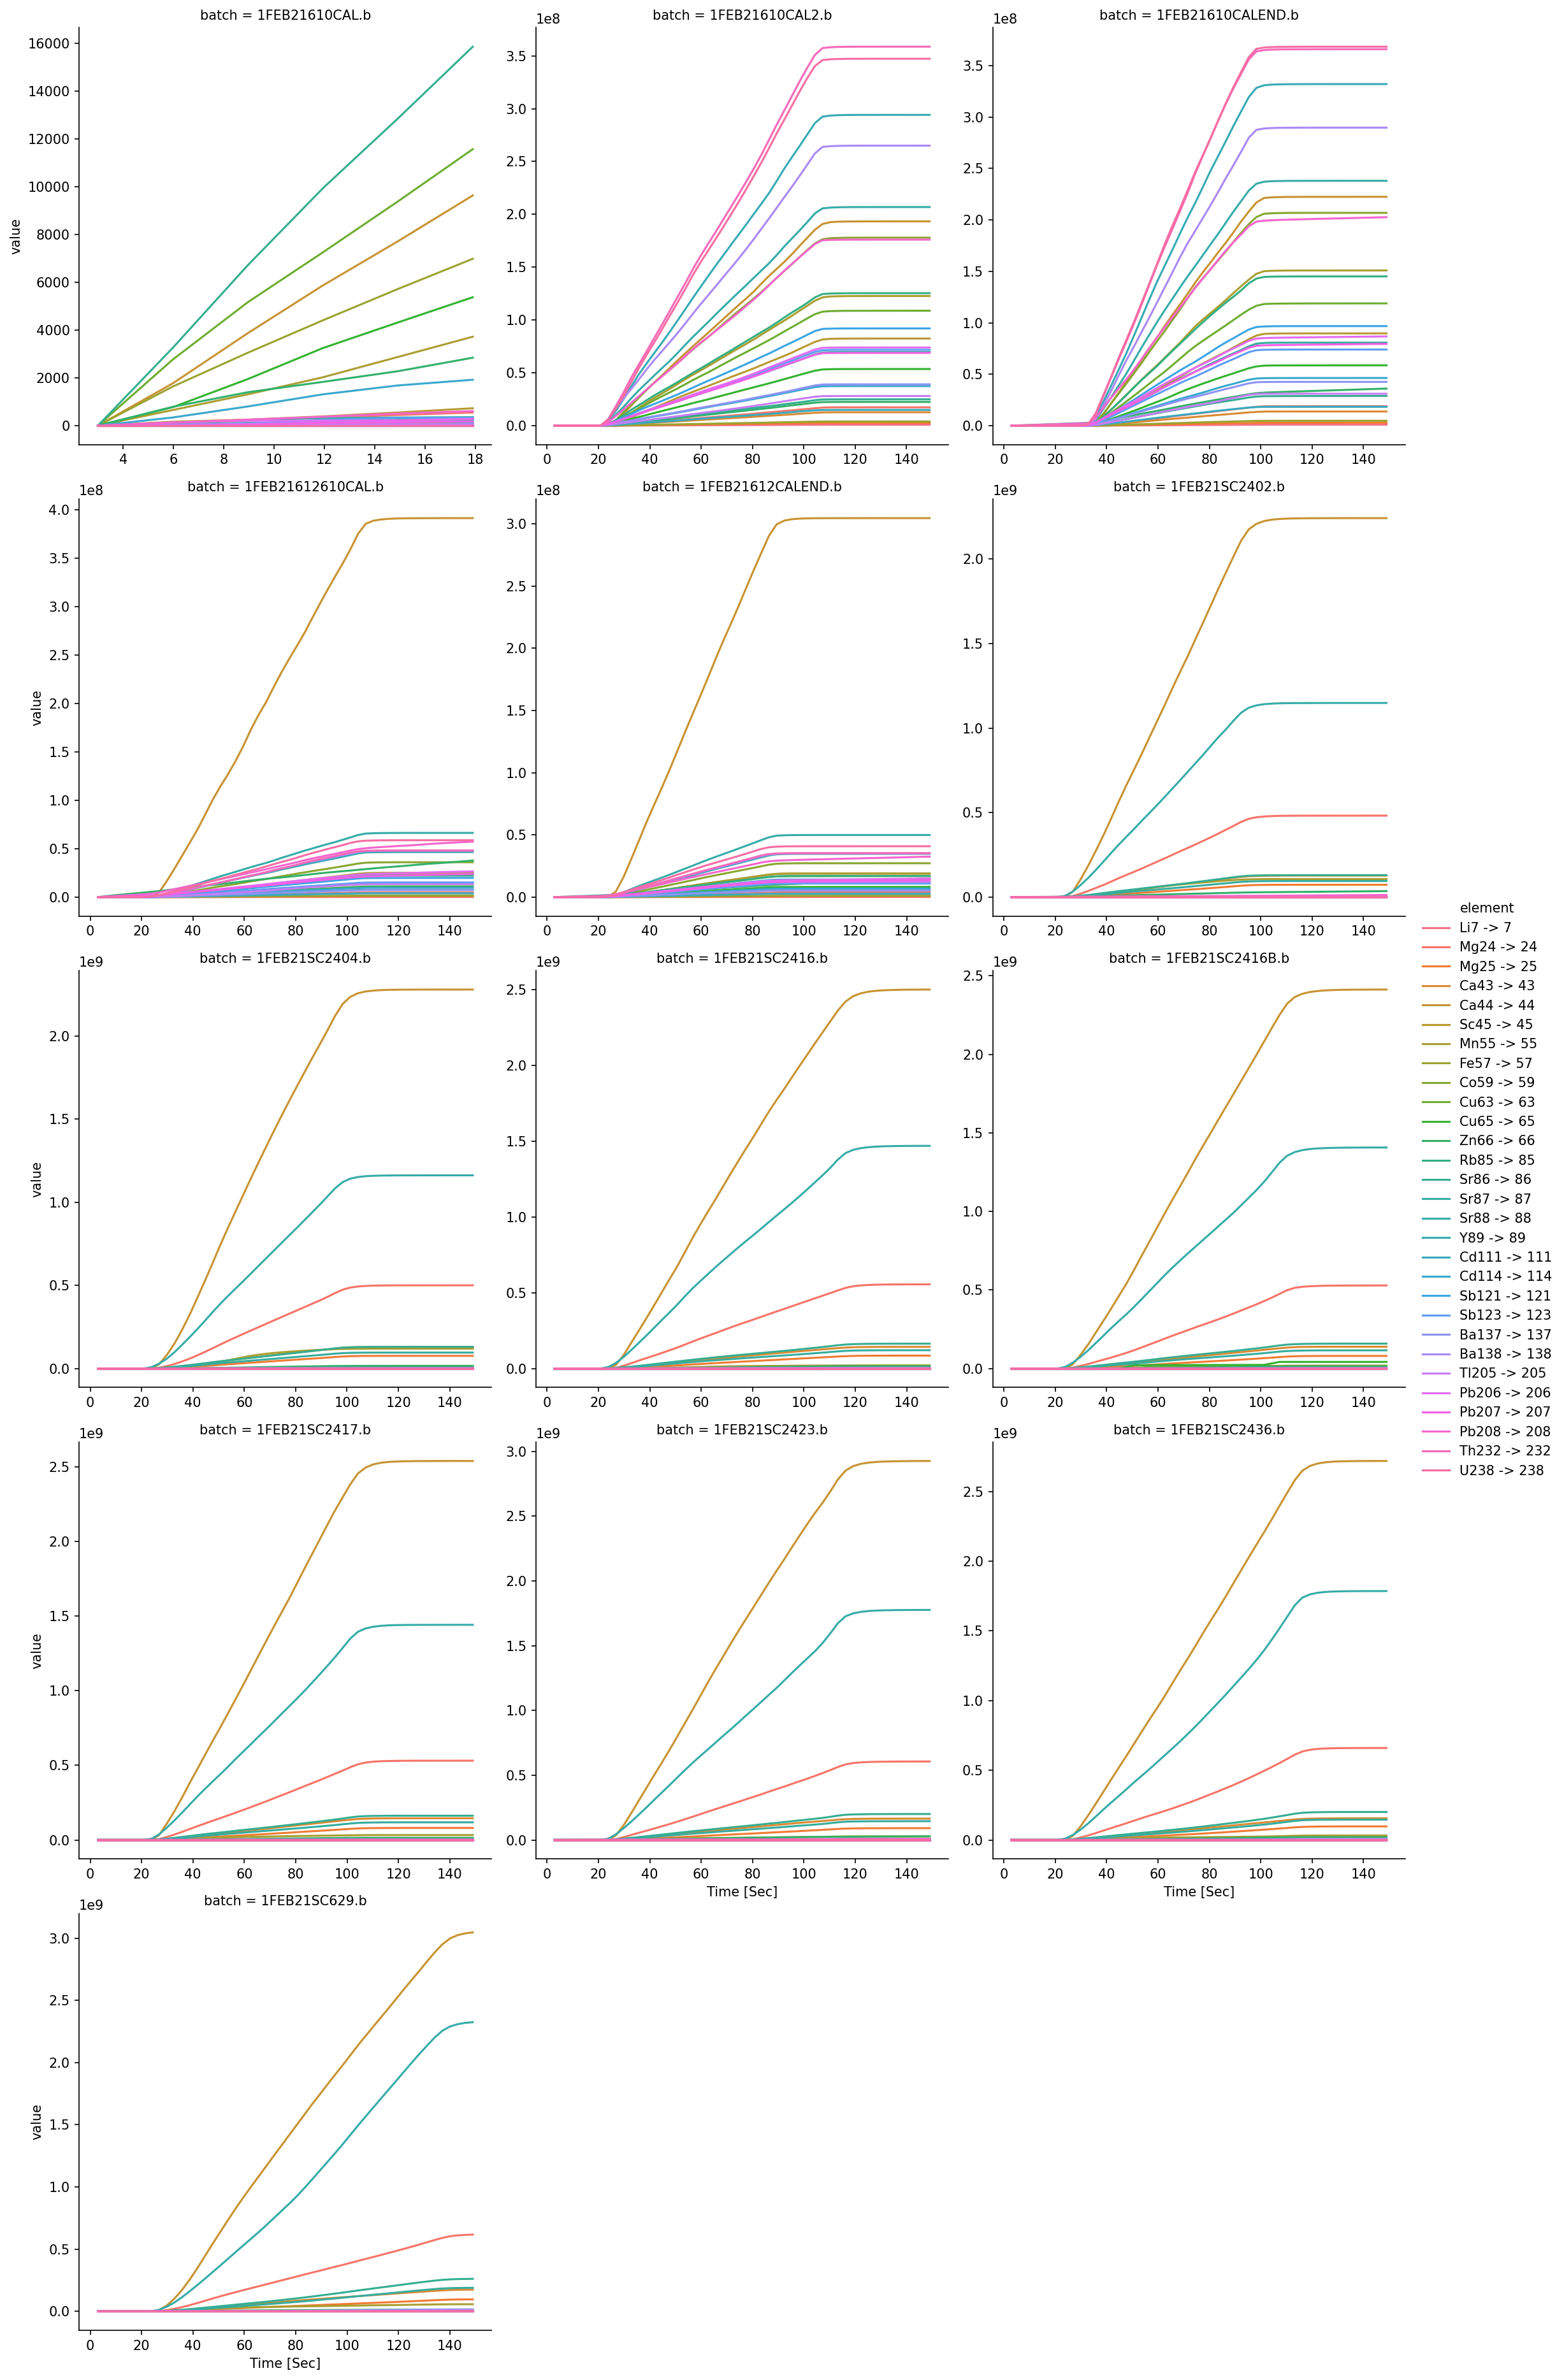

In [15]:
(
    df_cumtrap.reset_index(['batch']).melt(['batch','Time [Sec]'], var_name='element')
    .pipe(sns.FacetGrid, col='batch', col_wrap=3, hue='element', sharey=False, sharex=False, height=5)
    .map(plt.plot, 'Time [Sec]','value')
    .add_legend()
)

#plt.tight_layout()

# searching for csv files

In [ ]:
paths = list(Path('test/').glob('**/*.csv'))

df2 = load_paths(paths)

# total integral
df2_trap = get_trapz(df, meta_keys)

# cum integral
df2_cumtrap = get_cumtrapz(df, meta_keys)

In [ ]:
pd.testing.assert_frame_equal(df2_trap.droplevel('read_path'),df_trap.droplevel('read_path'))
pd.testing.assert_frame_equal(df2_cumtrap.droplevel('read_path'), df_cumtrap.droplevel('read_path'))

# Write to excel

In [ ]:
df_trap.rename_axis(columns=['element']).stack().to_frame('integrated_intensity').to_excel('output.xlsx')

In [ ]:
!open 'output.xlsx'

# working with xml? 
(NOTE: work in progress...)

In [ ]:
from urllib.request import urlretrieve
# from urllib import urlretrieve  # use this code for Python 2.x
urlretrieve ("http://proteowizard.sourceforge.net/example_data/tiny.pwiz.1.1.mzML", "test.mzML")

In [ ]:
import pyopenms
exp = pyopenms.MSExperiment()
pyopenms.MzMLFile().load("test.mzML", exp)

print( exp.getSpectrum(1).get_peaks()[0] )
# [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]

In [ ]:
exp = pyopenms.MSExperiment()

In [ ]:
pyopenms.MzXMLFile().load('./test/1FEB21610CAL.b/001SMPL.d/MSTS_XAddition.xml', exp)